<a href="https://colab.research.google.com/github/Tyred/TimeSeries_OCC-PUL/blob/main/OCC_Histogram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

from keras.layers import Input, Conv1D, Activation, MaxPooling1D, UpSampling1D, ZeroPadding1D, Cropping1D, Flatten
from keras.models import Model, load_model
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

from sklearn.metrics import mean_squared_error
%matplotlib inline

In [2]:
class Swish(Activation):
    def __init__(self, activation, **kwargs):
        super(Swish, self).__init__(activation, **kwargs)
        self.__name__ = 'swish'

def swish(x):
    return (K.sigmoid(x) * x)

get_custom_objects().update({'swish': Swish(swish)})

In [3]:
# Convolutional Autoencoder with MaxPooling:
class ConvAutoencoder():
  def __init__(self, serie_length):
    # encoder layers
    input_data = Input(shape=(serie_length, 1))
    x = Conv1D(128, (3), activation='swish', padding='same')(input_data)
    x = MaxPooling1D((2), padding='same')(x)
    x = Conv1D(64, (3), activation='swish', padding='same')(x)
    x = MaxPooling1D((2), padding='same')(x)
    x = Conv1D(1, (3), activation='swish', padding='same')(x)
  
    # encoded representation
    encoded = MaxPooling1D((2), padding='same')(x)
    
    # decoder layers
    x = Conv1D(1, (3), activation='swish', padding='same')(x)
    x = UpSampling1D((2))(encoded)
    x = Conv1D(64, (3), activation='swish', padding='same')(x)
    x = UpSampling1D((2))(x)
    x = Conv1D(128, (3), activation='swish', padding='same')(x)
    x = UpSampling1D((2))(x)
    x = Conv1D(1, (3), activation='linear', padding='same')(x)
    
    # cropping data so that decoded representation has the same shape as the input
    cropping = x.shape[1] - input_data.shape[1] 

    # decoded representation
    decoded = Cropping1D(cropping=(0,cropping))(x)
    
    # models
    self.encoder = Model(input_data, encoded)
    self.autoencoder = Model(input_data, decoded)
    self.autoencoder.compile(optimizer='adam', loss='mse')
    # summary
    self.autoencoder.summary()
    
  def train(self, data, epochs, batch_size):
    #self.callback = keras.callbacks.EarlyStopping(monitor='loss', patience=2)
    history = self.autoencoder.fit(data, data, epochs= epochs, batch_size= batch_size, validation_split=0.1) #, callbacks = [callback])
    
    return self.autoencoder

# Convolutional Autoencoder with Strides:
class ConvAutoencoderStrides():
  def __init__(self, serie_length):
    # encoder layers
    input_data = Input(shape=(serie_length, 1))
    x = Conv1D(128, (3), strides=2, activation='swish', padding='same')(input_data)
    x = Conv1D(64, (3), strides=2, activation='swish', padding='same')(x)
    x = Conv1D(32, (3), strides=2, activation='swish', padding='same')(x)
    
    # encoded representation
    encoded = Conv1D(1, (3), activation='swish', padding='same')(x)
    
    # decoder layers
    x = Conv1D(1, (3), activation='swish', padding='same')(x)
    x = UpSampling1D((2))(encoded)
    x = Conv1D(64, (3), activation='swish', padding='same')(x)
    x = UpSampling1D((2))(x)
    x = Conv1D(128, (3), activation='swish', padding='same')(x)
    x = UpSampling1D((2))(x)
    x = Conv1D(1, (3), activation='tanh', padding='same')(x)
    
    # cropping data so that decoded representation has the same shape as the input
    cropping = x.shape[1] - input_data.shape[1] 
    # decoded representation
    decoded = Cropping1D(cropping=(0,cropping))(x)
    
    # models
    self.encoder = Model(input_data, encoded)
    self.autoencoder = Model(input_data, decoded)
    self.autoencoder.compile(optimizer='adam', loss='mse')
    # summary
    self.autoencoder.summary()
    
  def train(self, data, epochs, batch_size):
    #self.callback = keras.callbacks.EarlyStopping(monitor='loss', patience=2)
    history = self.autoencoder.fit(data, data, epochs= epochs, batch_size= batch_size, validation_split=0.1) #, callbacks = [callback])
    
    return self.autoencoder

In [4]:
path = 'drive/My Drive/UFSCar/FAPESP/IC/Data/UCRArchive_2018'

dataset = input('Dataset: ')
tr_data = np.genfromtxt(path + "/" + dataset + "/" + dataset + "_TRAIN.tsv", delimiter="\t",)
te_data = np.genfromtxt(path + "/" + dataset + "/" + dataset + "_TEST.tsv", delimiter="\t",)

print(tr_data[:, 0])

class_label = 1
tr_data = tr_data[tr_data[:,0] == class_label, 1:] # train
tc_data = te_data[te_data[:,0] == class_label, 1:] # target class - test
oc_data = te_data[te_data[:,0] != class_label, 1:] # other classes - test

print("Train data shape: ", tr_data.shape)
print("Test data shape (target class): ", tc_data.shape)
print("Test data shape (other class(es)): ", oc_data.shape)

Dataset: FordA
[-1.  1. -1. ... -1.  1. -1.]
Train data shape:  (1755, 500)
Test data shape (target class):  (639, 500)
Test data shape (other class(es)):  (681, 500)


In [5]:
# Initialize the Autoencoder
serie_length = tr_data.shape[1]
model = ConvAutoencoder(serie_length)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500, 1)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 500, 128)          512       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 250, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 250, 64)           24640     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 125, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 125, 1)            193       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 63, 1)             0   

In [6]:
# Train
batch_size = 32
epochs = 50

autoencoder = model.train(tr_data, epochs, batch_size)

Epoch 1/50
50/50 [==============================] - 35s 24ms/step - loss: 0.6315 - val_loss: 0.2167
Epoch 2/50
50/50 [==============================] - 1s 11ms/step - loss: 0.2059 - val_loss: 0.1737
Epoch 3/50
50/50 [==============================] - 1s 11ms/step - loss: 0.1812 - val_loss: 0.1660
Epoch 4/50
50/50 [==============================] - 1s 11ms/step - loss: 0.1756 - val_loss: 0.1609
Epoch 5/50
50/50 [==============================] - 1s 11ms/step - loss: 0.1697 - val_loss: 0.1577
Epoch 6/50
50/50 [==============================] - 1s 11ms/step - loss: 0.1702 - val_loss: 0.1537
Epoch 7/50
50/50 [==============================] - 1s 11ms/step - loss: 0.1655 - val_loss: 0.1513
Epoch 8/50
50/50 [==============================] - 1s 11ms/step - loss: 0.1629 - val_loss: 0.1500
Epoch 9/50
50/50 [==============================] - 1s 11ms/step - loss: 0.1638 - val_loss: 0.1489
Epoch 10/50
50/50 [==============================] - 1s 11ms/step - loss: 0.1596 - val_loss: 0.1479
Epoch 11

In [7]:
tc_data_reconstructed = autoencoder.predict(tc_data)
oc_data_reconstructed = autoencoder.predict(oc_data)
tr_data_reconstructed = autoencoder.predict(tr_data)
# Reshaping
tc_data_reconstructed.shape = tc_data_reconstructed.shape[0], tc_data_reconstructed.shape[1]
oc_data_reconstructed.shape = oc_data_reconstructed.shape[0], oc_data_reconstructed.shape[1]
tr_data_reconstructed.shape = tr_data_reconstructed.shape[0], tr_data_reconstructed.shape[1]


print("Target Class test shape:", tc_data_reconstructed.shape, tc_data.shape)
print("Other Class(es) test shape:", oc_data_reconstructed.shape, oc_data.shape)

Target Class test shape: (639, 500) (639, 500)
Other Class(es) test shape: (681, 500) (681, 500)


MSE: 0.08392482207131483


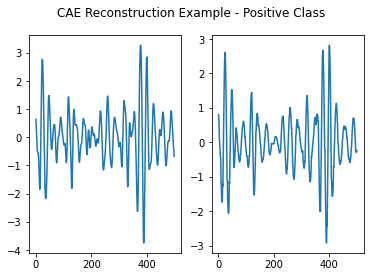

In [8]:
index = 22
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('CAE Reconstruction Example - Positive Class')
ax1.plot(tc_data[index])
ax2.plot(tc_data_reconstructed[index])
print("MSE:", mean_squared_error(tc_data[index], tc_data_reconstructed[index]))
fig.savefig(f'drive/My Drive/UFSCar/FAPESP/IC_2.0/Results/ex_{index}_{dataset}_pc.png') # Positive Class

MSE: 0.08987414333914523


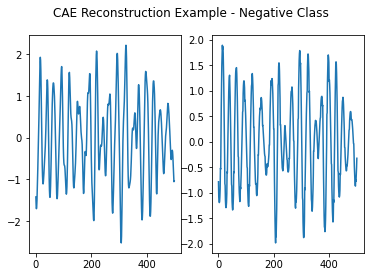

In [9]:
index = 8
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('CAE Reconstruction Example - Negative Class')
ax1.plot(oc_data[index])
ax2.plot(oc_data_reconstructed[index])
print("MSE:", mean_squared_error(oc_data[index], oc_data_reconstructed[index]))
fig.savefig(f'drive/My Drive/UFSCar/FAPESP/IC_2.0/Results/ex_{index}_{dataset}_nc.png') # Negative Class

In [10]:
def err_hist_occ(original_data, encoded_data):
  mse = []
  for i in range(original_data.shape[0]):
    mse.append(mean_squared_error(original_data[i], encoded_data[i]))

  mse = np.array(mse)
  mean = np.mean(mse)
  dp = np.std(mse)
  print("Média:", mean)
  print("Desvio padrão:", dp)

  return mse

Média: 0.1486325527272758
Desvio padrão: 0.0881391633040455


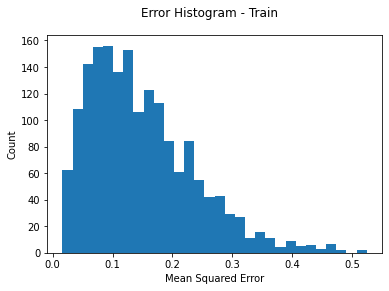

In [11]:
# Treino
plt.hist(err_hist_occ(tr_data, tr_data_reconstructed), bins = 30)
plt.ylabel('Count')
plt.xlabel('Mean Squared Error');
plt.suptitle('Error Histogram - Train')
plt.savefig(f'drive/My Drive/UFSCar/FAPESP/IC_2.0/Results/hist_{dataset}_train.png') # Train

Média: 0.15235841616250487
Desvio padrão: 0.09166519089632304
Accuracy positive class: 0.8466353677621283


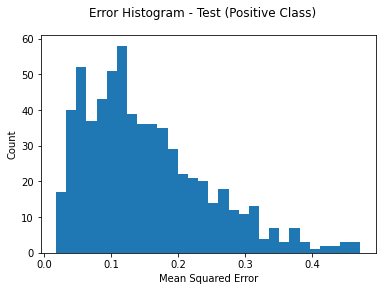

In [12]:
# Teste só com dado da classe de interesse
mse_pc = err_hist_occ(tc_data, tc_data_reconstructed) 

plt.hist(mse_pc, bins = 30)
plt.ylabel('Count')
plt.xlabel('Mean Squared Error');
plt.suptitle('Error Histogram - Test (Positive Class)')
plt.savefig(f'drive/My Drive/UFSCar/FAPESP/IC_2.0/Results/hist_{dataset}_pc.png') # Positive Class

# testing an arbitrary threshold
threshold = 0.25
accuracy = len(mse_pc[mse_pc <= threshold])/len(mse_pc)
print("Accuracy positive class:" , accuracy)

Média: 0.21618364496201642
Desvio padrão: 0.1853251990675194
Accuracy negative class: 0.39500734214390604


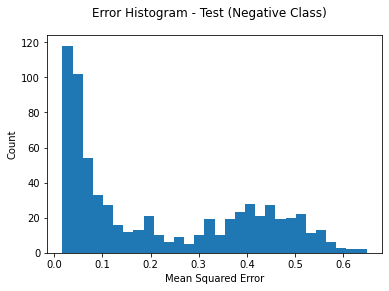

In [13]:
# Teste com dados da classe negativa
mse_nc = err_hist_occ(oc_data, oc_data_reconstructed)

plt.hist(mse_nc, bins = 30)
plt.ylabel('Count')
plt.xlabel('Mean Squared Error');
plt.suptitle('Error Histogram - Test (Negative Class)')
plt.savefig(f'drive/My Drive/UFSCar/FAPESP/IC_2.0/Results/hist_{dataset}_nc.png') # Negative Class

# testing an arbitrary threshold
threshold = 0.25
accuracy = len(mse_nc[mse_nc > threshold])/len(mse_nc)
print("Accuracy negative class:" , accuracy)

# **Alguns Testes aqui**


In [18]:
threshold = 0.25

In [19]:
mse = err_hist_occ(oc_data, oc_data_reconstructed)
false_positive = len(mse[mse<=threshold])
true_negative = len(mse[mse>threshold])
print("False Positive:", false_positive)
print("True Negative:", true_negative)

Média: 0.21618364496201642
Desvio padrão: 0.1853251990675194
False Positive: 412
True Negative: 269


In [20]:
mse = err_hist_occ(tc_data, tc_data_reconstructed)
true_positive = len(mse[mse<=threshold])
false_negative = len(mse[mse>threshold])
print("True Positive:", true_positive)
print("False Negative:", false_negative)

Média: 0.15235841616250487
Desvio padrão: 0.09166519089632304
True Positive: 541
False Negative: 98


In [21]:
total = false_positive + true_negative + true_positive + false_negative
print("Total:", total)
accuracy = (true_positive + true_negative)/total
precision = true_positive/(true_positive + false_positive)
recall = true_positive/(true_positive + false_negative)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Total: 1320
Accuracy: 0.6136363636363636
Precision: 0.5676810073452256
Recall: 0.8466353677621283


#**Definição do Threshold e Classificação**








In [ ]:
#Placeholder - Algoritmo para def de Threshold e Classificação